<div style="float:left;font-size:20px;">
    <h1>Interpolation</h1>
</div><div style="float:right;"><img src="../assets/banner.jpg"></div>

Illustrate option pricing with interpolation pricing and machine learning?

In [1]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Utilities

In [2]:
def build_european_option(strike_price, maturity_date, bsm_process, option_type=ql.Option.Call):
    payoff = ql.PlainVanillaPayoff(option_type, strike_price)
    eu_exercise = ql.EuropeanExercise(maturity_date)
    european_option = ql.VanillaOption(payoff, eu_exercise)
    european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
    return european_option

def build_bsm(spot_price, dividend_rate, calculation_date, volatility):
    spot_handle = ql.QuoteHandle(
        ql.SimpleQuote(spot_price)
    )

    flat_ts = ql.YieldTermStructureHandle(
        ql.FlatForward(calculation_date, risk_free_rate, day_count)
    )

    dividend_yield = ql.YieldTermStructureHandle(
        ql.FlatForward(calculation_date, dividend_rate, day_count)
    )

    flat_vol_ts = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(calculation_date, calendar, volatility, day_count)
    )
    bsm_process = ql.BlackScholesMertonProcess(spot_handle,
                                               dividend_yield,
                                               flat_ts,
                                               flat_vol_ts)
    return bsm_process

## Option Configuration

In [3]:
maturity_date = ql.Date(1, 1, 2020)
spot_price    = 0.8
strike_price  = 1
volatility    = 0.20 # the historical vols or implied vols
dividend_rate = 0 #0.0163
option_type   = ql.Option.Call

## Market configuration

In [4]:
risk_free_rate = 0 #0.001
day_count      = ql.Actual365Fixed()
calendar       = ql.UnitedStates()

calculation_date = ql.Date(1, 1, 2018)
ql.Settings.instance().evaluationDate = calculation_date

## Option objects

In [5]:
payoff          = ql.PlainVanillaPayoff(option_type, strike_price)
settlement      = calculation_date

am_exercise     = ql.AmericanExercise(settlement, maturity_date)
american_option = ql.VanillaOption(payoff, am_exercise)

eu_exercise     = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, eu_exercise)

## Simulation model - Black-Scholes-Merton

In [6]:
spot_handle = ql.QuoteHandle(
    ql.SimpleQuote(spot_price)
)

flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count)
)

dividend_yield = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count)
)

flat_vol_ts = ql.BlackVolTermStructureHandle(
    ql.BlackConstantVol(calculation_date, calendar, volatility, day_count)
)

bsm_process = ql.BlackScholesMertonProcess(spot_handle,
                                           dividend_yield,
                                           flat_ts,
                                           flat_vol_ts)

## Option Pricing

### Theoretical European option price

In [7]:
european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
bs_price = european_option.NPV()
print(bs_price)

0.030826523017186053


### Binomial tree pricing

In [8]:
def binomial_price(option, bsm_process, steps):
    binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", steps)
    option.setPricingEngine(binomial_engine)
    return option.NPV()

min_steps = 5
max_steps = 500

steps = range(min_steps, max_steps)
eu_prices = [binomial_price(european_option, bsm_process, step) for step in steps]
am_prices = [binomial_price(american_option, bsm_process, step) for step in steps]

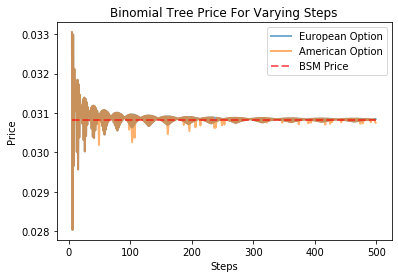

In [9]:
plt.plot(steps, eu_prices, label="European Option", lw=2, alpha=0.6)
plt.plot(steps, am_prices, label="American Option", lw=2, alpha=0.6)
plt.plot([min_steps, max_steps], [bs_price, bs_price], "r--", label="BSM Price", lw=2, alpha=0.6)
plt.xlabel("Steps")
plt.ylabel("Price")
#plt.ylim(6.7, 7)
plt.title("Binomial Tree Price For Varying Steps")
plt.legend()

In [10]:
def price_convergence_measure(price):
    diff = np.array(price) - np.roll(price, -1)
    return diff[:-1]

In [11]:
price_convergence_measure(am_prices)[-10:]

array([-8.18629716e-06,  7.58376174e-05, -7.32474672e-05,  1.31644114e-07,
        2.62639861e-06, -5.04682992e-06,  7.97001189e-06, -1.01867232e-05,
        7.24830736e-05,  1.57646254e-05])

In [12]:
%timeit binomial_price(american_option, bsm_process, 1000)

7.33 ms ± 58.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Interpolation pricing

In [13]:
min_strike = spot_price - 1
max_strike = spot_price + 1

### Brute force

In [14]:
def strike_prices(strikes, n_steps=1000, settlement=settlement, maturity_date=maturity_date):
    am_exercise     = ql.AmericanExercise(settlement, maturity_date)
    american_options = [ql.VanillaOption(ql.PlainVanillaPayoff(option_type, strike), am_exercise) for strike in strikes]
    prices = [binomial_price(american_option, bsm_process, n_steps) for american_option in american_options]
    return strikes, prices

In [15]:
def scan_strike_prices(strike_min, strike_max, n_strikes=100, n_steps=1000):
    strikes = np.linspace(strike_min, strike_max, n_strikes)
    return strike_prices(strikes, n_steps)

In [16]:
# 726 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
strikes, prices = scan_strike_prices(min_strike, max_strike)

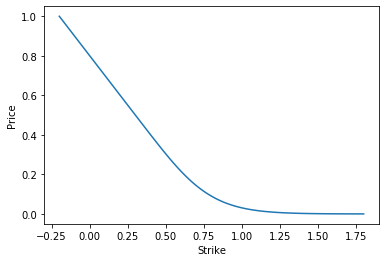

In [17]:
plt.plot(strikes, prices)
plt.xlabel("Strike")
plt.ylabel("Price");

### Interpolation (1D)

In [18]:
spot_handle = ql.QuoteHandle(
    ql.SimpleQuote(0.5)
)

bsm_process = ql.BlackScholesMertonProcess(spot_handle,
                                           dividend_yield,
                                           flat_ts,
                                           flat_vol_ts)

def option_prices(strikes, n_steps=1000, settlement=settlement, maturity_date=maturity_date, bsm_process=bsm_process):
    eu_exercise     = ql.EuropeanExercise(maturity_date)
    european_options = [ql.VanillaOption(ql.PlainVanillaPayoff(option_type, strike), eu_exercise) for strike in strikes]
    prices = [binomial_price(european_option, bsm_process, n_steps) for european_option in european_options]
    return prices

In [19]:
def theory_option_prices(spots, maturity=maturity_date):
    """Get BS option price for a range of spots"""
    prices = []
    for spot in spots:
        bsm_process = build_bsm(spot, dividend_rate, calculation_date, volatility)
        european_option = build_european_option(strike_price, maturity, bsm_process)
        prices.append(european_option.NPV())

    return prices

In [78]:
def gridpoints(n, a=-1, b=1):
    """Returns Chebyshev nodes of specified dimensions.
    
    int n: Number of Chebyshev nodes
    float a: Interval minimum
    float b: Interval maximum
    
    Further reading: https://en.wikipedia.org/wiki/Chebyshev_nodes
    """
    x_i = 0.5*(b + a) + 0.5*(b - a) * np.cos( np.pi * (np.arange(1, n + 1) - 0.5)/n)
    return np.array(sorted(x_i))

In [21]:
from scipy import interpolate
def evaluate_interp(x_eval, y_true, f_interp):
    y_interp = f_interp(x_eval)
    y_error = np.abs(y_interp - y_true)
    return y_interp, y_error

In [22]:
# Generate train set
n = 10
#x_interp = gridpoints(10, a=min_strike, b=max_strike)  # Strikes
x_interp = gridpoints(n, a=0.8, b=1.2)  # Spots
spot_div_strike = np.array(x_interp)/strike_price
data = theory_option_prices(x_interp)

# Train interpolation
f_interp_lin = interpolate.interp1d(x_interp, data, kind='linear')
f_interp_cubic = interpolate.interp1d(x_interp, data, kind='cubic')
f_interp_bary = interpolate.BarycentricInterpolator(x_interp, data)

In [23]:
theory_option_prices([1])

[0.1124629160182849]

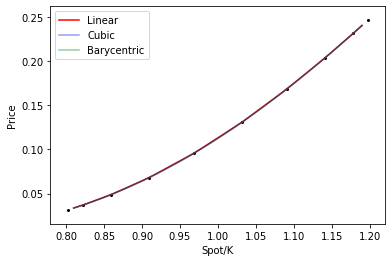

In [24]:
# Evaluate performance
#x_eval = np.linspace(min_strike+1.5, max_strike-1.5, 200)
x_eval = np.linspace(0.81, 1.19, 30)  # Spots
spot_div_strike = x_eval/strike_price
y_true = theory_option_prices(x_eval)

y_interp_lin, y_error_lin = evaluate_interp(x_eval, y_true, f_interp_lin)
y_interp_cubic, y_error_cubic = evaluate_interp(x_eval, y_true, f_interp_cubic)
y_interp_bary, y_error_bary = evaluate_interp(x_eval, y_true, f_interp_bary)

plt.scatter(x_interp, data, color='black', s=4)
plt.plot(x_eval, y_interp_lin, color='r', label='Linear')
plt.plot(x_eval, y_interp_cubic, color='b', alpha=0.4, label='Cubic')
plt.plot(x_eval, y_interp_bary, color='g', alpha=0.4, label='Barycentric')
plt.ylabel('Price')
plt.xlabel('Spot/K')
plt.legend();


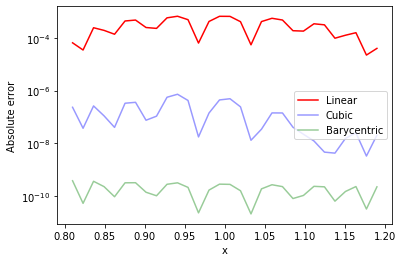

In [25]:
plt.plot(x_eval, y_error_lin, color='r', label='Linear')
plt.plot(x_eval, y_error_cubic, color='b', alpha=0.4, label='Cubic')
plt.plot(x_eval, y_error_bary, color='g', alpha=0.4, label='Barycentric')
plt.xlabel('x')
plt.ylabel('Absolute error')
plt.yscale('log')
plt.legend();

### Interpolation (2D) options

In [79]:
# Generate train set
n = 3
x_maturity = gridpoints(n, a=0.5, b=2)  # Maturities
y_spot = gridpoints(n, a=0.8, b=1.2)  # Spots

points, values = [], []
z_price = []
for mat in x_maturity:
    maturity = calculation_date + int(365/mat)  # Approximate date diff
    prices = theory_option_prices(y_spot, maturity)
    values.append(prices) 
values = np.array(values)

In [80]:
# Points specficies the grid nodes (1D arrays) for each dimension
points = (x_maturity, y_spot)
points

(array([0.60048095, 1.25      , 1.89951905]),
 array([0.82679492, 1.        , 1.17320508]))

In [84]:
values = x_maturity.transpose()**2 - y_spot
values

array([-0.46621755,  0.5625    ,  2.43496755])

Look at: https://github.com/JohannesBuchner/regulargrid
         https://stackoverflow.com/questions/30056577/correct-usage-of-scipy-interpolate-regulargridinterpolator

In [82]:
# Train interpolator
from scipy.interpolate import RegularGridInterpolator
#f_3d_interp = RegularGridInterpolator((x_maturity, y_spot), np.array(values))
f_3d_interp = RegularGridInterpolator(points, values)

ValueError: There are 2 point arrays, but values has 1 dimensions

In [74]:
f_3d_interp((x_maturity[1], y_spot[0]))

array(0.01196583)

In [49]:
# Evaluate performance
n_spots = 3
n_mats = 3

x_maturity_eval = np.linspace(0.61, 1.89, n_mats)  # Maturities
y_spot_eval = np.linspace(0.91, 1.09, n_spots)  # Spots
spot_div_strike = y_spot_eval/strike_price

x_maturity_eval = np.array(x_maturity)
y_spot_eval = np.array(y_spot)


# True values
z_true = []
for mat in x_maturity_eval:
    maturity = calculation_date + int(365/mat)  # Approximate date diff
    prices = theory_option_prices(y_spot_eval, maturity)
    z_true.append(prices)   

# Interpolated values
points_x, points_y = np.broadcast_arrays(x_maturity_eval.reshape(1, -1, 1), y_spot_eval.reshape(-1, 1, 1))
coord = np.vstack((points_x.flatten(), 
               points_y.flatten()
               )).T
z_interp = f_3d_interp(coord)

# Compute the error
error = np.abs(z_interp - np.array(z_true).flatten())
error

array([0.        , 0.00986584, 0.02778803, 0.05279879, 0.08472485,
       0.1223407 , 0.1620447 , 0.19869952, 0.22686834, 0.24214125,
       0.00986584, 0.        , 0.01786756, 0.04280099, 0.07476877,
       0.11267855, 0.15288883, 0.19012469, 0.2187874 , 0.23433504,
       0.02778803, 0.01786756, 0.        , 0.02491905, 0.05710081,
       0.09568363, 0.13693193, 0.17530418, 0.20490894, 0.22097269,
       0.05279879, 0.04280099, 0.02491905, 0.        , 0.03248791,
       0.07198791, 0.11462842, 0.15449666, 0.18532128, 0.20204534,
       0.08472485, 0.07476877, 0.05710081, 0.03248791, 0.        ,
       0.0401844 , 0.084077  , 0.12534777, 0.1573169 , 0.17465732,
       0.1223407 , 0.11267855, 0.09568363, 0.07198791, 0.0401844 ,
       0.        , 0.0445395 , 0.0867006 , 0.11941739, 0.13716123,
       0.1620447 , 0.15288883, 0.13693193, 0.11462842, 0.084077  ,
       0.0445395 , 0.        , 0.04246799, 0.07547852, 0.0933841 ,
       0.19869952, 0.19012469, 0.17530418, 0.15449666, 0.12534

In [121]:
len(z_interp)

9

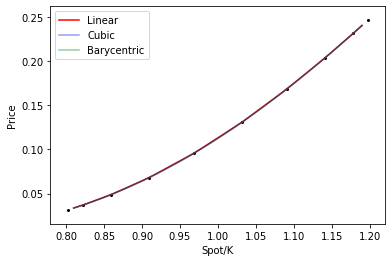

In [50]:

y_interp_lin, y_error_lin = evaluate_interp(x_eval, y_true, f_interp_lin)
y_interp_cubic, y_error_cubic = evaluate_interp(x_eval, y_true, f_interp_cubic)
y_interp_bary, y_error_bary = evaluate_interp(x_eval, y_true, f_interp_bary)

plt.scatter(x_interp, data, color='black', s=4)
plt.plot(x_eval, y_interp_lin, color='r', label='Linear')
plt.plot(x_eval, y_interp_cubic, color='b', alpha=0.4, label='Cubic')
plt.plot(x_eval, y_interp_bary, color='g', alpha=0.4, label='Barycentric')
plt.ylabel('Price')
plt.xlabel('Spot/K')
plt.legend();


In [72]:
f_3d_interp((0.9, 1))

array(0.05423738)

In [52]:
#points = np.random.rand(1000, 2)
#values = func(points[:,0], points[:,1])

# Grid interpolation
from scipy.interpolate import griddata
grid_z2 = griddata(points, values, (x_maturity, y_spot), method='cubic')

ValueError: invalid number of dimensions in xi

In [64]:
grid_z2

array([-0.00138212, -0.07227491,  0.00139495,  0.02371238,         nan,
               nan,         nan,         nan,         nan,         nan])

TypeError: Invalid shape (10,) for image data

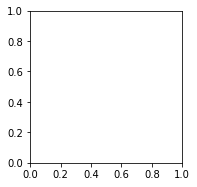

In [63]:

plt.subplot(122)
plt.imshow(grid_z2.T, extent=(0,1,0,1), origin='lower')
plt.title('Cubic');

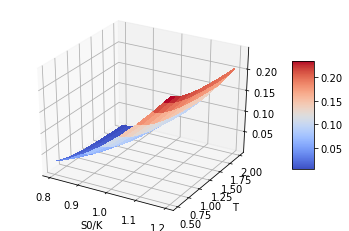

In [60]:
# Visualise interpolation points
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

X, Y = np.meshgrid(x_spot, y_maturity)
Z = np.array(z_price)

fig = plt.figure()
ax = fig.gca(projection='3d')


surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.xlabel('S0/K')
plt.ylabel('T')

fig.colorbar(surf, shrink=0.5, aspect=5)

In [53]:

X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
X

array([[-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       ...,
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75]])

In [ ]:


# Actual results
grid_z_actual = func(grid_x, grid_y)

# Only know values at 1000 points
points = np.random.rand(1000, 2)
values = func(points[:,0], points[:,1])

# Grid interpolation
from scipy.interpolate import griddata
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

### Interpolation (2D)

In [26]:
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

# Actual results
grid_z_actual = func(grid_x, grid_y)

# Only know values at 1000 points
points = np.random.rand(1000, 2)
values = func(points[:,0], points[:,1])

# Grid interpolation
from scipy.interpolate import griddata
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

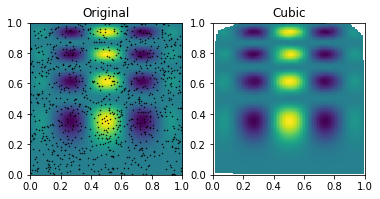

In [27]:
# Original
plt.subplot(121)
plt.imshow(grid_z_actual.T, extent=(0,1,0,1), origin='lower')
plt.plot(points[:,0], points[:,1], 'k.', ms=1)
plt.title('Original')

# Interpolation
plt.subplot(122)
plt.imshow(grid_z2.T, extent=(0,1,0,1), origin='lower')
plt.title('Cubic');

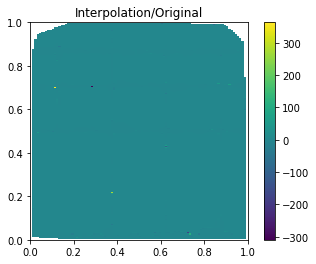

In [28]:
ratio = grid_z_actual/grid_z2

plt.imshow(ratio.T, extent=(0,1,0,1), origin='lower')
plt.colorbar()
plt.title('Interpolation/Original');

In [29]:
def am_option_price(strike, day_delta, settlement_date, maturity_date, steps=500):
    am_exercise     = ql.AmericanExercise(settlement, maturity_date)
    american_option = ql.VanillaOption(ql.PlainVanillaPayoff(option_type, strike), am_exercise)
    price = binomial_price(american_option, bsm_process, steps)
    return price

In [30]:
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

grid_strike, grid_mat = np.mgrid[100:200:100j, 0:1:200j]

In [31]:
a = ql.Date(8, 5, 2015)
a += 1
a

Date(9,5,2015)

## Chebyshev

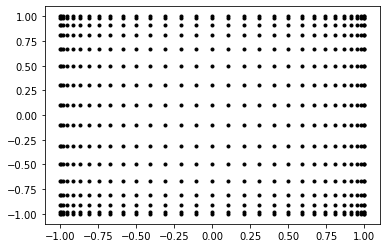

In [32]:
import numpy as np
import matplotlib.pyplot as plt
N = 30
M = 15
x = np.cos (np.pi * np.arange(N + 1) / N)
y = np.cos (np.pi * np.arange(M + 1) / M)
xx, yy = np.meshgrid(x, y)
plt.plot(xx, yy, "ko", markersize = 3);

In [33]:
x = np.arange(N + 1)
y = np.arange(N + 1)
c = np.arange(N + 1)
np.polynomial.chebyshev.Chebyshev.interpolate(, 3)

SyntaxError: invalid syntax (<ipython-input-33-669e54416b06>, line 4)

## Trade population

In [ ]:
n_trades = 100
tickers = ['AAPL', 'SPY']
currencies = ['USD']
products = ['AmericanOption']
maturities = [ql.Date(15, 1, 2016)]

np.random.seed(42)
quantities = np.linspace(-100000, 100000, 21)

tick_data = pd.DataFrame({'Ticker': tickers,
                          'Spot': np.random.randint(100, 200, len(tickers)),
                          'DividendRate': np.random.uniform(0.005, 0.015, len(tickers)),
                         })
tick_data

In [ ]:
population['Call'].apply(lambda x: callPutStr(x))


In [ ]:
def callPutStr(call):
    if call:
        return 'C'
    else:
        return 'P'

population = pd.DataFrame({'TradeID': ['EQ{}'.format(i + 1) for i in range(n_trades)],
                           'Ticker': np.random.choice(tickers, size=n_trades),
                           'Currency': np.random.choice(currencies, size=n_trades),
                           'Product': np.random.choice(products, size=n_trades),
                           'Call': np.random.choice([True, False], size=n_trades),
                           'Maturity': np.random.choice(maturities, size=n_trades),
                           'Quantity': np.random.choice(quantities, size=n_trades),
                          })
population['Strike'] = population.apply(lambda row: tick_data[tick_data['Ticker']==row['Ticker']]['Spot'].values[0], axis=1)
population['Instrument'] = population['Ticker'] + '.' + population['Strike'].astype('str') + '.' + population['Call'].apply(lambda x: callPutStr(x))
population

In [ ]:
tick_data